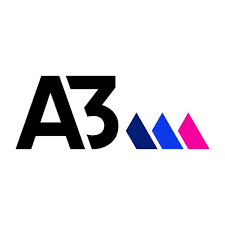 

# Desafio Técnico

## Objetivo Geral:
* Exploração da Base de dados usando técnicas de NLP

### Objetivos Específicos:
* Exploração da base 
* Encontrar quais tópicos são mais frequentes na base (embora a base seja relacinadadas a empresa, qual serão os tipos de empresas?)
* Comparar dois modelos estado da arte para realizar resumo das sentenças

## Metodologia:
* Primeiramente verificamos a distribuição das sentenças a nível de letras e palavras
* Verificamos quais stop-words são mais frequentes
* Analisamos quais tópicos(assuntos) aparecem mais entre as empresas
* Aplicamos a tarefa de sumarização e comparação de dois modelos.

## Resultados
* Descrevemos ao longo das células

## Tarefas Futuras
* Poderíamos aplicar uma tarefas de geração de perguntas dado a definição da empresa. Isso poderia ser útil para geração de ground truth sintético para uma possível tarefa de Q&A.

* Encontrar empresas que são semelhantes dados os embeddings (doc2vec, sbert) dado o tópico. E realizar um rank das top 5 empresas mais semelhantes por tópico (searching)

* Também vejo que poderíamos tentar reconhecer entidades, localização... 

#### Obs: Tivemos problemas de conflito de libraries no colab. Para agilizar o processo, é importante a execução das células conforme a ordem estabelecida neste notebook.

In [1]:
import plotly.express as px

In [2]:
! pip install transformers
! pip install pyLDAvis
! pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 20.3 MB/s 
     |████████████████████████████████| 596 kB 70.9 MB/s 
     |████████████████████████████████| 101 kB 6.3 MB/s 
     |████████████████████████████████| 6.6 MB 13.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=7332f44a91a5cd2bed6240e71d1eb23f6d133d6f8b86278d1d30cfd1b714b347
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 105 kB 23.3 MB/s 
     |████████████████████████████████| 2.0 MB 54.7 MB/s 


In [3]:
import tensorflow as tf
import transformers
from transformers import pipeline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from collections import  Counter
import sklearn
import gensim
import pyLDAvis
import wordcloud
import textblob
import spacy
import textstat
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## Distribuição de caracteres e palavras

In [6]:
df = pd.read_csv('id_desc.csv')

In [7]:
df.head(3)

,id,desc
0,004c744a-2b82-49b3-a536-90dbb68f368e,Vectra is a cybersecurity platform that uses A...
1,0062d2eb-8210-480a-adef-ec91d0e74855,Roadzen is a global leader in the P&C insuranc...
2,00657562-4dd3-41f9-aceb-df114606bc9e,Restream is a multi-streaming solution that al...


In [8]:
df.dropna(inplace=True)

In [9]:
# Aqui olhamos a distribuição por caractere
fig = px.histogram(df.desc.str.len().to_frame(),x='desc', title='Distribuição por quantidade de caractere.')
fig.show()

In [10]:
## Aqui olhamos pela quantidade de palavra
df_freq = df.desc.str.split().map(lambda x: len(x)).to_frame()
fig = px.histogram(df_freq, x='desc', title='Distribuição por quantidade de palavras.')
fig.show()

In [11]:
df_freq.describe()

,desc
count,3553.000000
mean,75.155925
std,55.134310
min,2.000000
25%,40.000000
50%,67.000000
75%,97.000000
max,780.000000


In [12]:
## Aqui olhamos a média do tamanho das palavras
df_freq = df.desc.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).to_frame()
fig = px.histogram(df_freq, x='desc', title='Média do tamanho das palvras por sentenças.')
fig.show()

## Analisando stop words e as palavras com mais frequências

In [13]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
desc = df.desc.str.split()
desc = desc.values.tolist()
corpus=[word for i in desc for word in i]

In [15]:
## Criamos nosso dicionário de stop_words com suas respectivas frequência
from collections import defaultdict
dic_stop=defaultdict(int)
for word in corpus:
    if word in stop:
        dic_stop[word]+=1

In [16]:
## Ordenamos e mostramos a distribuição dos 10 "stop words" mais frequentes
top=sorted(dic_stop.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y = zip(*top)
fig = px.bar(x=x, y=y, title='Frequêndia das 10 stop words mais frequentes.')
fig.show()

In [17]:
## Aqui verificamos quais palavras mais frequentes e que não são stop words
cnt = Counter(corpus)
m_common = cnt.most_common()

In [18]:
x, y= [], []
for word,count in m_common[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)

In [19]:
fig = px.bar(x=y, y=x, title='Palavras mais frequentes.')
fig.show()

## Buscamos encontrar quais os tópicos mais importantes entre as descrições das empresas.

* Primeiramento fazemos um preprocessamento
** Retiramos stop words
** Tokenizamos
** Lematizamos
** Criamos sentenças
* Aplicamos a técnica LDA para encontrar as palavras mais relevantes por tópicos

In [20]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_desc(df):
  corpus=[]
  lem=WordNetLemmatizer()
  for desc in df['desc']:
    
      words=[w for w in word_tokenize(desc) if (w not in stop)]
      
      words=[lem.lemmatize(w) for w in words if len(w)>2]
      
      corpus.append(words)
  return corpus

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [21]:
corpus = preprocess_desc(df)

In [22]:
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [23]:
print(dic)

Dictionary(25217 unique tokens: ['2011', '365', 'And', 'Azure', 'California.Read']...)


In [24]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 6, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.014*"data" + 0.013*"More" + 0.012*"platform" + 0.010*"company" + 0.007*"care" + 0.006*"technology" + 0.006*"solution" + 0.006*"The" + 0.005*"service" + 0.005*"business"'),
 (1,
  '0.012*"More" + 0.009*"data" + 0.008*"company" + 0.008*"platform" + 0.005*"technology" + 0.005*"solution" + 0.004*"patient" + 0.004*"learning" + 0.004*"customer" + 0.003*"The"'),
 (2,
  '0.012*"company" + 0.012*"More" + 0.011*"data" + 0.008*"solution" + 0.008*"service" + 0.008*"customer" + 0.008*"platform" + 0.007*"The" + 0.006*"business" + 0.006*"technology"'),
 (3,
  '0.012*"company" + 0.011*"More" + 0.010*"platform" + 0.007*"health" + 0.005*"technology" + 0.005*"healthcare" + 0.005*"service" + 0.005*"The" + 0.005*"customer" + 0.004*"data"'),
 (4,
  '0.014*"company" + 0.010*"More" + 0.006*"solution" + 0.005*"platform" + 0.005*"The" + 0.005*"founded" + 0.004*"product" + 0.004*"patient" + 0.004*"technology" + 0.003*"healthcare"'),
 (5,
  '0.012*"company" + 0.012*"More" + 0.009*"platform" + 0.007*"The

In [25]:
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.030873 -0.028953       1        1  26.277301
2      0.025029 -0.034374       2        1  23.463685
5      0.032476  0.058112       3        1  18.152049
1      0.008279 -0.049065       4        1  13.132983
3      0.017735  0.049061       5        1  12.262265
4     -0.114391  0.005219       6        1   6.711717, topic_info=         Term         Freq        Total Category  logprob  loglift
33    company  2032.000000  2032.000000  Default  30.0000  30.0000
10       More  2117.000000  2117.000000  Default  29.0000  29.0000
790   payment   307.000000   307.000000  Default  28.0000  28.0000
45    founded   584.000000   584.000000  Default  27.0000  27.0000
135  solution  1005.000000  1005.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
184      help    27.686116   698.188610   Topic6  -6.0738  -0.5262
530  software    26.135265   604.279650   Topic6  -6.1315  -0.4394
790   payment    21.522520   307.449469   Topic6  -6.3257   0.0421
490  provider    21.878886   464.346208   Topic6  -6.3092  -0.3538
207  customer    22.397617   926.208819   Topic6  -6.2858  -1.0208

[508 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
24434      6  0.797349  2Morrow
13939      1  0.873688  AIgatha
13810      4  0.888722   ANGOKA
12184      3  0.881658      APP
2207       1  0.888327      AWS
...      ...       ...      ...
107        2  0.202159    world
107        3  0.175367    world
107        4  0.192416    world
107        5  0.129089    world
107        6  0.034099    world

[1065 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 6, 2, 4, 5])

#### Descoberta/Resultado

* Percebemos que as empresas versam sobre tecnologia, heathcare, business, etc.

## Usamos a tarefa de sumarização para comparar dois modelos state-of-art.

* A ideia é primeiramente reduzir o tamanho das descrições das empresas.

* Secundariamente comparamos dois modelos.

* Usamos o modelo pré-treinado t5-base e o modelo bart
* Usamos a métrica BLEU para realizar gerar um score e comparar os modelos

In [26]:
summarizer_t5 = pipeline("summarization", model="t5-base", tokenizer="t5-base", framework="tf")
summarizer_bart = pipeline("summarization")

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [27]:
from tqdm import tqdm
import time

def generate_summary(sp, model, column_name):
  summ = list()
  tp = list()
  for row in tqdm(sp.desc):
    start = time.time()
    summ.append(model(row, min_length=10, max_length=30)[0]['summary_text']) 
    end = time.time()
    tp.append((end-start))
  sp[column_name] = summ
  sp[column_name+'s'] = tp
  return sp

In [28]:
sample = df.sample(n=30, random_state=1023)
sample = generate_summary(sample,summarizer_t5,'t5_summ')
sample = generate_summary(sample,summarizer_bart,'bart_summ')

100%|██████████| 30/30 [01:49<00:00,  3.65s/it]


In [29]:
sample.head(2)

,id,desc,t5_summ,t5_summs,bart_summ,bart_summs
66,1e1bc341-11fc-40f4-a25d-25f044a532b9,Zipnosis is a hospital and healthcare company ...,Zipnosis is a hospital and healthcare company ...,21.399418,Zipnosis is a hospital and healthcare company...,3.678064
3412,ec72dc06-a42c-4f4b-8eba-53e8620d34c5,Repeat is a SaaS platform that enables consume...,CPG brands use Repeat to give their customers ...,19.544151,Repeat is a SaaS platform that enables consum...,3.364659


In [30]:
from nltk.translate.bleu_score import sentence_bleu
def get_bleu_score(sp):
  bl_t5 = list()
  bl_b = list()
  for index, row in sp.iterrows():
    bl_t5.append(sentence_bleu([row['desc'].split()], row['t5_summ'].split(),weights=(1, 0, 0, 0)))
    bl_b.append(sentence_bleu([row['desc'].split()], row['bart_summ'].split(),weights=(1, 0, 0, 0)))
  sp['blue_t5'] = bl_t5
  sp['blue_b'] = bl_b
  return sp

In [31]:
df_final = get_bleu_score(sample)

In [32]:
# df_final = pd.read_csv('final_table.csv')

In [33]:
df_final.head(2)

,id,desc,t5_summ,t5_summs,bart_summ,bart_summs,blue_t5,blue_b
66,1e1bc341-11fc-40f4-a25d-25f044a532b9,Zipnosis is a hospital and healthcare company ...,Zipnosis is a hospital and healthcare company ...,21.399418,Zipnosis is a hospital and healthcare company...,3.678064,0.150142,0.212279
3412,ec72dc06-a42c-4f4b-8eba-53e8620d34c5,Repeat is a SaaS platform that enables consume...,CPG brands use Repeat to give their customers ...,19.544151,Repeat is a SaaS platform that enables consum...,3.364659,0.168227,0.346239


In [34]:
fig = px.box(df_final, y=['blue_t5','blue_b'], title='Distribuição dos Scores')
fig.show()

#### Descoberta/Resultado

* Aqui verificamos que o modelo bart aparesenta um BLEU score um pouco melhor do que o t5.

* Não podemos afirmar que um é melhor do que o outro, pois a métrica apenas compara os n-grams e também não temos um ground truth.

* Aqui poderíamos usar a métrica envolvendo os vetores de embeddings (cosseno) para fazer uma comparação mais semântica.

In [35]:
from scipy import stats
from scipy.stats import kstest, wilcoxon

print(kstest(df_final.blue_t5,stats.norm.cdf),kstest(df_final.blue_b,stats.norm.cdf))

KstestResult(statistic=0.5000000307930429, pvalue=1.84672709996904e-07) KstestResult(statistic=0.5000009952898581, pvalue=1.846604854854707e-07)


In [36]:
wilcoxon(df_final.blue_t5,df_final.blue_b)

WilcoxonResult(statistic=54.0, pvalue=0.0006914625550684938)

#### Descoberta/Resultado

* As distribuições relacionadas ao score de cada modelo não apresentam normalidade
* E elas são de distribuições diferentes

In [37]:
fig = px.box(df_final, y=['t5_summs','bart_summs'],title='Distribuição dos tempos de geração')
fig.show()

#### Descoberta/Resultado

* O tempo de geração de texto é menor para o Bart do que para t5.
* Não podemos descartar a discussão do tempo sem levar em consideração a complexidade do modelo e sua arquitetura.